In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
acct_df = pd.read_parquet(Path('../../q2data/q2-ucsd-acctDF.pqt'))
cons_df = pd.read_parquet(Path('../../q2data/q2-ucsd-consDF.pqt'))
trxn_df = pd.read_parquet(Path('../../q2data/q2-ucsd-trxnDF.pqt'))

In [26]:
acct_df.balance_date = pd.to_datetime(acct_df.balance_date)
acct_df = acct_df.astype({'prism_consumer_id': int, 'prism_account_id': int})

cons_df.evaluation_date = pd.to_datetime(cons_df.evaluation_date)
cons_df = cons_df.astype({'prism_consumer_id': int})

trxn_df.posted_date = pd.to_datetime(trxn_df.posted_date)
trxn_df = trxn_df.astype({'prism_consumer_id': int, 'prism_transaction_id': int})

In [27]:
display(acct_df, cons_df, trxn_df)

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0
...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN
14996,14996,2022-01-15,625.0,NaN
14997,14997,2022-01-31,688.0,NaN
14998,14998,2022-03-08,722.0,NaN


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31


In [31]:
# different account types
acct_df.account_type.value_counts()

account_type
CHECKING           15467
SAVINGS             7751
CREDIT CARD          691
LOAN                 127
LINE OF CREDIT        93
CONSUMER              73
BROKERAGE             66
CD                    45
MONEY MARKET          36
AUTO                  29
MORTGAGE              22
PREPAID               19
OTHER                 12
IRA                    9
ROTH                   5
CASH MANAGEMENT        5
401K                   4
RETIREMENT             3
STUDENT                2
HSA                    2
OVERDRAFT              2
MONEYMARKET            1
STOCK PLAN             1
HOME EQUITY            1
Name: count, dtype: int64

In [32]:
# number of consumers that hold x number of accounts
acct_df.groupby('prism_consumer_id').count().prism_account_id.value_counts()

prism_account_id
2     6038
1     5038
3     1179
4      404
5      173
6       76
7       41
8       18
9       14
10      12
11       7
12       6
14       1
13       1
25       1
Name: count, dtype: int64

In [52]:
(acct_df.balance <= 0).sum()

1936

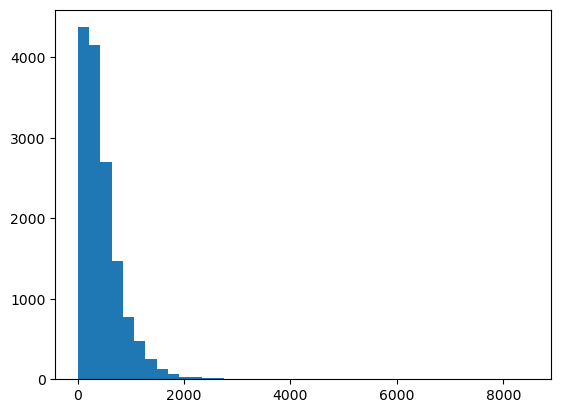

In [48]:
trxn_counts = trxn_df.groupby('prism_consumer_id').count().prism_transaction_id

# distribution of number of transactions per consumer
plt.hist(trxn_counts, bins=40)
plt.show()

In [3]:
cons_df_no_na = cons_df[~cons_df['DQ_TARGET'].isna()]

## Week 1 

**Single best feature to predict `DQ_TARGET`**

**Simple**
- sum of a consumer's `balance`
- `credit_score` seems like an obvious one
- sum of consumer's credit - sum of consumer's debit

In [5]:
import scipy

In [6]:
debit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'DEBIT']['category'].value_counts().index)
credit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'CREDIT']['category'].value_counts().index)

In [7]:
sum_of_balance = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                   .rename(columns={'balance': 'sum_of_balance'}).reset_index()
cons_sum_balance_df = cons_df_no_na.merge(sum_of_balance, left_on='prism_consumer_id', right_on='prism_consumer_id')

In [16]:
cons_sum_balance_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,sum_of_balance
0,0,2021-09-01,726.0,0.0,320.37
1,1,2021-07-01,626.0,0.0,3302.42
2,2,2021-05-01,680.0,0.0,2805.36
3,3,2021-03-01,734.0,0.0,7667.01
4,4,2021-10-01,676.0,0.0,394.55
...,...,...,...,...,...
10403,13995,2022-01-22,802.0,0.0,1028.80
10404,13996,2022-02-01,652.0,0.0,11495.77
10405,13997,2021-12-24,765.0,0.0,2396.85
10406,13998,2022-01-30,685.0,0.0,14835.71


**Note: balances have different meaning based on account type, i.e. a credit card balance (outflow) vs checkings balance (inflow)**

In [8]:
sum_balance_r2 = np.corrcoef(cons_sum_balance_df['DQ_TARGET'], cons_sum_balance_df['sum_of_balance'])[0][1]**2
sum_balance_r2

0.0015695061588102432

In [9]:
cons_sum_balance_dq0 = cons_sum_balance_df[cons_sum_balance_df["DQ_TARGET"] == 0.0]
cons_sum_balance_dq1 = cons_sum_balance_df[cons_sum_balance_df["DQ_TARGET"] == 1.0]
scipy.stats.ks_2samp(cons_sum_balance_dq0["sum_of_balance"], cons_sum_balance_dq1["sum_of_balance"]).pvalue

3.7555463168404585e-99

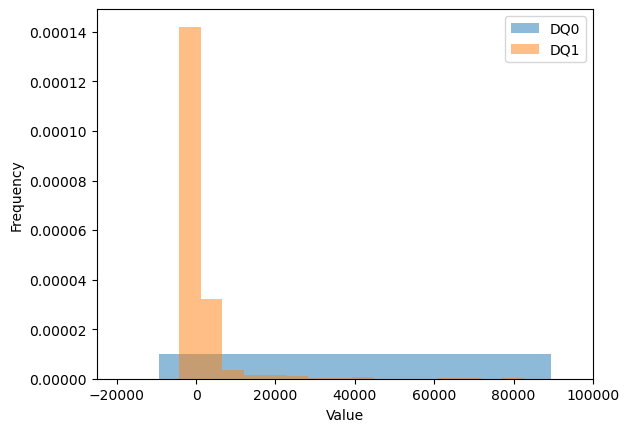

In [10]:
plt.hist(cons_sum_balance_dq0["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_sum_balance_dq1["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ1")

# Add labels and legend
plt.xlim(-25000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

In [11]:
credit_score_r2 = np.corrcoef(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])[0][1]**2
credit_score_r2

0.06828206045598226

In [12]:
credit_debit = trxn_df.groupby('prism_consumer_id').apply(lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                                               - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum())

/tmp/ipykernel_279/3680999254.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  credit_debit = trxn_df.groupby('prism_consumer_id').apply(lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()


In [13]:
cons_credit_minus_debit_df = cons_df_no_na.merge(pd.DataFrame(credit_debit).reset_index().rename(columns={0: "credit_minus_debit"}), left_on='prism_consumer_id', right_on='prism_consumer_id')
cons_credit_minus_debit_dq0 = cons_credit_minus_debit_df[cons_credit_minus_debit_df["DQ_TARGET"] == 0.0]
cons_credit_minus_debit_dq1 = cons_credit_minus_debit_df[cons_credit_minus_debit_df["DQ_TARGET"] == 1.0]
scipy.stats.ks_2samp(cons_credit_minus_debit_dq0["credit_minus_debit"], cons_credit_minus_debit_dq1["credit_minus_debit"]).pvalue

1.643182347946055e-26

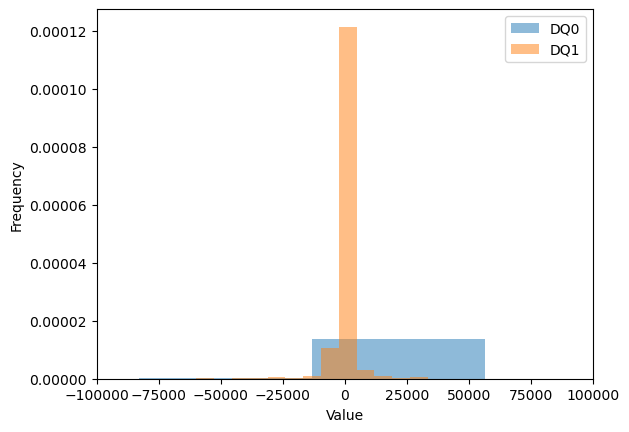

In [14]:
plt.hist(cons_credit_minus_debit_dq0["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_credit_minus_debit_dq1["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ1")

# Add labels and legend
plt.xlim(-100000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

## Week 2

**New balance features**
- percent change in balance from earliest date to latest date
- account balance less than 0
  
**New income features**
- number of income transactions
- standard deviation of income
- number of income sources

In [99]:
# should determine the consumers that don't appear in acct_df or trxn_df, remove them from training data

In [97]:
len(cons_df.prism_consumer_id.unique())

15000

In [98]:
len(trxn_df.prism_consumer_id.unique())

14492

In [96]:
len(acct_df.prism_consumer_id.unique())

13009

In [230]:
def calc_balance_delta(rand_cons):
    # rand_cons = acct_df.sample(n=1).prism_consumer_id.values[0]
    rand_cons_acct_df = acct_df[acct_df.prism_consumer_id == rand_cons]
    rand_cons_trxn_df = trxn_df[trxn_df.prism_consumer_id == rand_cons].sort_values(by='posted_date')
    
    avg_balance_date = np.mean(rand_cons_acct_df.balance_date)
    balance = sum(rand_cons_acct_df.balance)
    
    before_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date <= avg_balance_date]
    after_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date > avg_balance_date]
    
    initial_balance = balance + sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "DEBIT"].amount) - \
                               sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "CREDIT"].amount) 
    ending_balance = balance + sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "CREDIT"].amount) - \
                               sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "DEBIT"].amount) 
    if initial_balance == 0:
        return 1
    else:
        return ((ending_balance - initial_balance) / initial_balance)

In [231]:
# growth in balance for each consumer
balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)

0       -0.379272
1        3.245659
2        0.203075
3        0.481150
4       -1.421784
           ...   
14995    1.000000
14996    0.147716
14997    1.000000
14998    1.000000
14999    0.174805
Name: prism_consumer_id, Length: 15000, dtype: float64

In [213]:
rand_cons = acct_df.sample(n=1).prism_consumer_id.values[0]
rand_cons_acct_df = acct_df[acct_df.prism_consumer_id == rand_cons]
rand_cons_trxn_df = trxn_df[trxn_df.prism_consumer_id == rand_cons].sort_values(by='posted_date')

avg_balance_date = np.mean(rand_cons_acct_df.balance_date)
balance = sum(rand_cons_acct_df.balance)

before_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date <= avg_balance_date]
after_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date > avg_balance_date]

initial_balance = balance + sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "DEBIT"].amount) - \
                           sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "CREDIT"].amount) 
ending_balance = balance + sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "CREDIT"].amount) - \
                           sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "DEBIT"].amount) 
print((ending_balance - initial_balance) / initial_balance)
display(before_balance_date_df, after_balance_date_df)

23.11567379988438


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
1749899,9772,1747887,2,100.00,CREDIT,2023-04-08
1749952,9772,1747940,19,40.00,DEBIT,2023-04-08
1749953,9772,1747941,16,1.87,DEBIT,2023-04-09
1749954,9772,1747942,40,1.50,DEBIT,2023-04-11
1749955,9772,1747943,14,12.44,DEBIT,2023-04-12
...,...,...,...,...,...,...
1750037,9772,1748025,14,34.47,DEBIT,2023-06-27
1750038,9772,1748026,27,4.00,DEBIT,2023-06-28
1750039,9772,1748027,14,24.92,DEBIT,2023-06-29
1750040,9772,1748028,14,13.73,DEBIT,2023-06-30


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date


In [235]:
# number of "income" sources for each consumer
num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()

In [236]:
# standard deviation of inflows
std_income = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['amount'].std()

prism_consumer_id
0         494.177258
1         383.271173
2         609.314103
3         844.130789
4         368.114382
            ...     
14995     329.312758
14996    1076.542076
14997    2448.997302
14998    1701.940647
14999     394.697351
Name: amount, Length: 14476, dtype: float64

**NEXT STEPS**
- begin considering category nuances
- more specific time recurrence